In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

np.random.seed(72)
tf.random.set_seed(72)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



In [3]:
def evaluate_(model, generator_test):
    model.evaluate(generator_test)
    
    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.show()

In [4]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_(model, generator_test):
    model.evaluate(generator_test)
    
    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    
    # ROC curve
    plt.subplot(1, 2, 2)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(len(class_labels)):
        plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# Call the function with your model and test generator


In [5]:
train_dir = r"/kaggle/input/leaf-dataset/augmented/train"
test_dir = r"/kaggle/input/leaf-dataset/augmented/test"
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)


datagen_test = ImageDataGenerator(rescale=1./255)


batch_size = 16
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=(112, 112),
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=(112, 112),
                                                  batch_size=batch_size,
                                                  shuffle=False)
# Calculate class weights
labels = generator_train.classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = dict(zip(np.unique(labels), class_weights))
print(class_weights)

Found 5000 images belonging to 30 classes.
Found 2500 images belonging to 30 classes.
{0: 1.2820512820512822, 1: 0.4975124378109453, 2: 1.0101010101010102, 3: 1.016260162601626, 4: 0.5827505827505828, 5: 1.8726591760299625, 6: 0.778816199376947, 7: 1.2345679012345678, 8: 1.1111111111111112, 9: 0.9057971014492754, 10: 1.3440860215053763, 11: 0.8680555555555556, 12: 0.9009009009009009, 13: 0.6587615283267457, 14: 0.778816199376947, 15: 1.3123359580052494, 16: 0.9416195856873822, 17: 1.02880658436214, 18: 1.4880952380952381, 19: 1.1037527593818985, 20: 1.4492753623188406, 21: 1.3888888888888888, 22: 1.0040160642570282, 23: 1.0964912280701755, 24: 0.8169934640522876, 25: 0.8960573476702509, 26: 1.529051987767584, 27: 1.0964912280701755, 28: 1.1574074074074074, 29: 1.6181229773462784}


In [6]:
!pip install keras_cv_attention_models 

  Obtaining dependency information for keras_cv_attention_models from https://files.pythonhosted.org/packages/f0/02/d10f684e57fc993cc90c9c7610df4e77239f8d1c395f67c3e687109eae6b/keras_cv_attention_models-1.3.23-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 kB 1.7 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for ftfy from https://files.pythonhosted.org/packages/91/f8/dfa32d06cfcbdb76bc46e0f5d69c537de33f4cedb1a15cd4746ab45a6a26/ftfy-6.1.3-py3-none-any.whl.metadata
  Obtaining dependency information for wcwidth<0.3.0,>=0.2.12 from https://files.pythonhosted.org/packages/31/b1/a59de0ad3aabb17523a39804f4c6df3ae87ead053a4e25362ae03d73d03a/wcwidth-0.2.12-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 786.9/786.9 kB 10.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.6
    Uninstalli

In [8]:
from keras_cv_attention_models import wave_mlp

In [10]:
pip install keras-self-attention


Note: you may need to restart the kernel to use updated packages.


In [12]:
def modify_wave_mlp(input_shape, num_classes):
    # Load the WaveMLP model without the top layers (head)
    mm_headless = wave_mlp.WaveMLP_T(input_shape=input_shape, pretrained="imagenet")

    # Initialize x with the output of the base model
    x = mm_headless.output

    # Stage 2 with HDC
    x = stage_block(x, filters=128, num_blocks=3, hdc=True)

    # Stage 3 with HDC
    x = stage_block(x, filters=256, num_blocks=3, hdc=True)

    # Stage 4 (Residual blocks)
    x = stage_block(x, filters=512, num_blocks=3, attention=False, hdc=False)

    # Custom head
    head_output = custom_head(x, num_classes)

    # Create the custom model by combining the base model and the custom head
    custom_model = Model(inputs=mm_headless.input, outputs=head_output)

    return custom_model


In [24]:
input_shape = (112, 112, 3)
num_classes = 26

# Assign the result of modify_wave_mlp to a variable
custom_model = modify_wave_mlp(input_shape, num_classes)

# Now you can use custom_model outside of the function
mm_last_layer = custom_model.get_layer('avg_pool').output
mm_custom = Model(custom_model.input, mm_last_layer)


>>>> Load pretrained from: /root/.keras/models/wavemlp_t_imagenet.h5


In [26]:
# custom_model.summary()

In [27]:
from tensorflow.keras import layers
inputs = keras.Input(shape=(112,112,3))
outputs = layers.average([mm_custom(inputs)])

avg_ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
avg_ensemble_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 model_1 (Functional)        (None, 512)               16704736  
                                                                 
 average (Average)           (None, 512)               0         
                                                                 
Total params: 16704736 (63.72 MB)
Trainable params: 16680160 (63.63 MB)
Non-trainable params: 24576 (96.00 KB)
_________________________________________________________________


In [29]:
num_classes = 30
avg_ensemble_model_last_layer = avg_ensemble_model.get_layer('average').output
output_layer = Dense(num_classes, activation='softmax', name='output_1')(avg_ensemble_model_last_layer)
final_model = Model(avg_ensemble_model.input, output_layer)

final_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 model_1 (Functional)        (None, 512)               16704736  
                                                                 
 average (Average)           (None, 512)               0         
                                                                 
 output_1 (Dense)            (None, 30)                15390     
                                                                 
Total params: 16720126 (63.78 MB)
Trainable params: 16695550 (63.69 MB)
Non-trainable params: 24576 (96.00 KB)
_________________________________________________________________


In [30]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
# metrics = ['categorical_accuracy']
metrics = ['accuracy', 'categorical_accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
           tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), 
           tf.keras.metrics.FalseNegatives(), tfa.metrics.CohenKappa(num_classes = num_classes), 
           tfa.metrics.F1Score(num_classes = num_classes)]

final_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,
    patience=9, mode="max", min_delta=0.0001, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint(filepath='Best_DenseNet201_v23.h5', save_best_only=True, monitor = 'val_accuracy', verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

callbacks = [lr, checkpoint, early_stopping]

In [32]:
epochs = 30

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

history = final_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test,
                                   callbacks=callbacks, class_weight =class_weights)

/tmp/ipykernel_42/2027776823.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = final_model.fit_generator(generator=generator_train,


Epoch 1/30
313/312 [==============================] - ETA: 0s - loss: 1.3088 - accuracy: 0.6172 - categorical_accuracy: 0.6172 - auc: 0.9599 - precision: 0.7536 - recall: 0.4894 - true_positives: 2447.0000 - true_negatives: 144200.0000 - false_positives: 800.0000 - false_negatives: 2553.0000 - cohen_kappa: 0.6032 - f1_score: 0.6079
Epoch 1: val_accuracy improved from -inf to 0.69840, saving model to Best_DenseNet201_v23.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


312/312 [==============================] - 182s 371ms/step - loss: 1.3088 - accuracy: 0.6172 - categorical_accuracy: 0.6172 - auc: 0.9599 - precision: 0.7536 - recall: 0.4894 - true_positives: 2447.0000 - true_negatives: 144200.0000 - false_positives: 800.0000 - false_negatives: 2553.0000 - cohen_kappa: 0.6032 - f1_score: 0.6079 - val_loss: 0.9990 - val_accuracy: 0.6984 - val_categorical_accuracy: 0.6984 - val_auc: 0.9725 - val_precision: 0.7685 - val_recall: 0.6348 - val_true_positives: 1587.0000 - val_true_negatives: 72022.0000 - val_false_positives: 478.0000 - val_false_negatives: 913.0000 - val_cohen_kappa: 0.6875 - val_f1_score: 0.6712 - lr: 0.0010
Epoch 2/30
313/312 [==============================] - ETA: 0s - loss: 0.6249 - accuracy: 0.8076 - categorical_accuracy: 0.8076 - auc: 0.9873 - precision: 0.8560 - recall: 0.7586 - true_positives: 3793.0000 - true_negatives: 144362.0000 - false_positives: 638.0000 - false_negatives: 1207.0000 - cohen_kappa: 0.8004 - f1_score: 0.7990
Epoc

157/157 [==============================] - 22s 131ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       0.99      1.00      1.00       153
           2       0.98      1.00      0.99        84
           3       1.00      1.00      1.00        72
           4       1.00      1.00      1.00       124
           5       1.00      1.00      1.00        47
           6       1.00      1.00      1.00        99
           7       0.97      1.00      0.98        84
           8       1.00      0.65      0.79        66
           9       1.00      1.00      1.00        84
          10       1.00      1.00      1.00        78
          11       0.91      0.97      0.94        75
          12       0.99      1.00      0.99        85
          13       0.95      1.00      0.97       126
          14       1.00      1.00      1.00        92
          15       1.00      1.00      1.00        89
          16       1.00

/tmp/ipykernel_42/2485669865.py:45: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


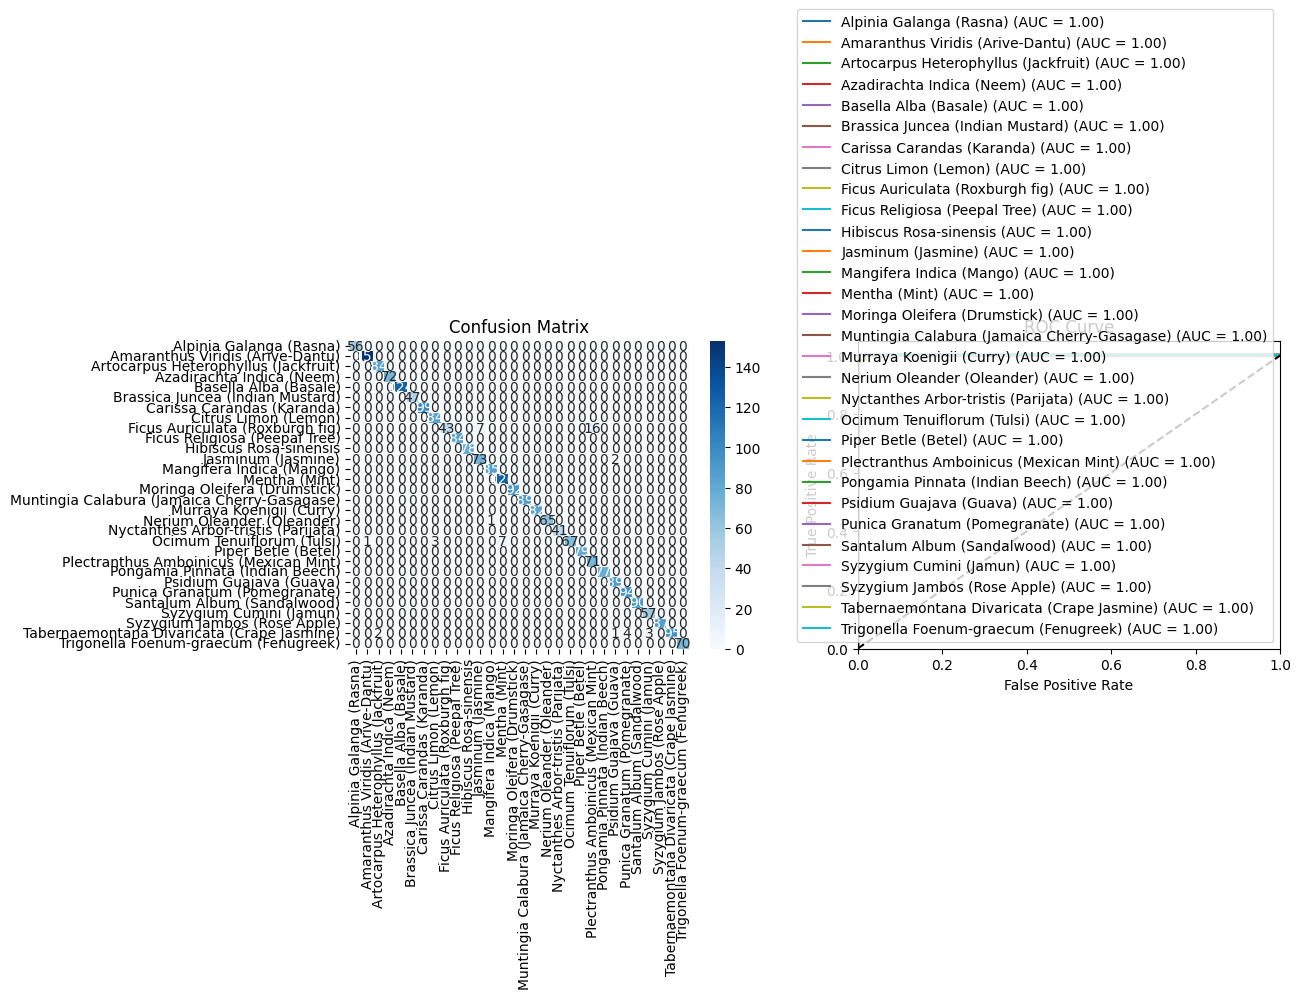

In [33]:
evaluate_(final_model, generator_test)